In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv('house_prices.csv')

# Preview data
print("First 5 Rows:\n", df.head())

# Check missing values
print("\nMissing Values:\n", df.isnull().sum())

# Handle missing values
df.fillna(df.mean(numeric_only=True), inplace=True)
df['Location'].fillna(df['Location'].mode()[0], inplace=True)

First 5 Rows:
    Size  Location  Number of Rooms   Price
0  1649     urban                5  282035
1  1458     rural                3  123235
2  1694     rural                6  221965
3  1956  suburban                4  231253
4  1429     urban                2  166956

Missing Values:
 Size               0
Location           0
Number of Rooms    0
Price              0
dtype: int64


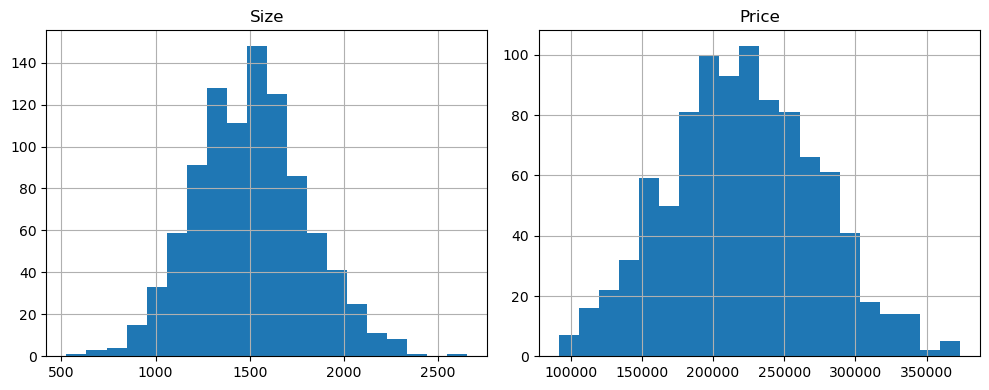

In [2]:
# Distribution of Size and Price
df[['Size', 'Price']].hist(bins=20, figsize=(10, 4))
plt.tight_layout()
plt.show()

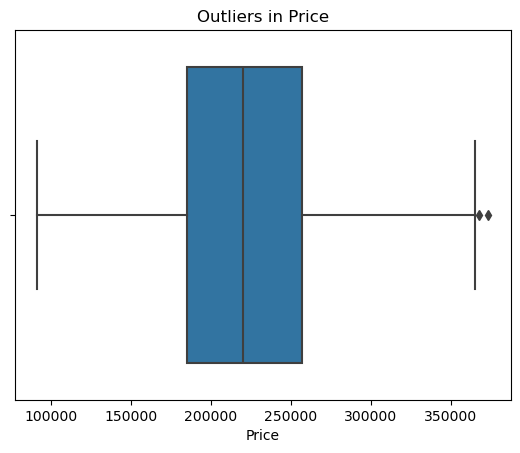

In [3]:
# Boxplot for outliers
sns.boxplot(x=df['Price'])
plt.title("Outliers in Price")
plt.show()


In [6]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
# Define features and target
X = df[['Size', 'Location', 'Number of Rooms']]
y = df['Price']
# Specify preprocessing steps
numeric_features = ['Size', 'Number of Rooms']
categorical_features = ['Location']
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ]
)
# Fit and transform the features
X_processed = preprocessor.fit_transform(X)
# Get transformed feature names
ohe = preprocessor.named_transformers_['cat']
encoded_cat_features = ohe.get_feature_names_out(categorical_features)
all_feature_names = numeric_features + list(encoded_cat_features)

# Convert to DataFrame for display
X_processed_df = pd.DataFrame(X_processed.toarray() if hasattr(X_processed, "toarray") else X_processed,
                              columns=all_feature_names)
# Display first 5 rows of preprocessed data
print("Preprocessed Feature Set:\n", X_processed_df.head())

Preprocessed Feature Set:
        Size  Number of Rooms  Location_suburban  Location_urban
0  0.488520         0.664837                0.0             1.0
1 -0.161801        -0.735596                0.0             0.0
2  0.641737         1.365054                0.0             0.0
3  1.533801        -0.035379                1.0             0.0
4 -0.260541        -1.435813                0.0             1.0


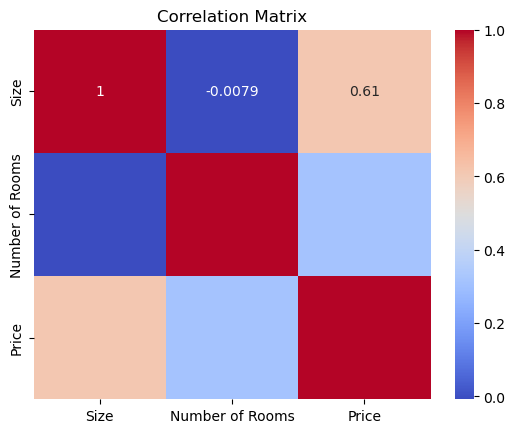

In [8]:
# Correlation matrix
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Create pipeline with preprocessing and regression
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Train model
model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Size', 'Number of Rooms']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['Location'])])),
                ('regressor', LinearRegression())])

In [10]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Predict on test set
y_pred = model.predict(X_test)

# Evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"\nRoot Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

# Compare actual vs predicted
comparison_df = pd.DataFrame({'Actual Price': y_test, 'Predicted Price': y_pred})
print("\nSample Predictions:\n", comparison_df.head())



Root Mean Squared Error (RMSE): 19983.71
R² Score: 0.85

Sample Predictions:
      Actual Price  Predicted Price
199        154535    160141.878373
929        192569    185414.225846
693        216787    208454.458370
798        261584    233408.693459
874        264801    258696.159119


In [11]:
# Feature importance for linear regression
regressor = model.named_steps['regressor']
encoder = model.named_steps['preprocessor'].named_transformers_['cat']
ohe_features = encoder.get_feature_names_out(['Location'])
all_features = numeric_features + list(ohe_features)

coef_df = pd.DataFrame({
    'Feature': all_features,
    'Coefficient': regressor.coef_
})
print("\nFeature Importance:\n", coef_df)



Feature Importance:
              Feature   Coefficient
0               Size  33623.648422
1    Number of Rooms  15884.280123
2  Location_suburban  41249.171107
3     Location_urban  79777.619149
